## Problem 2: CART-RF-ANN
## Vikram Radhakrishnan, May 10, 2020

In [1232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [1233]:
df = pd.read_csv("insurance_part2_data.csv")

In [1234]:
df.head(5)

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [1235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
Age             3000 non-null int64
Agency_Code     3000 non-null object
Type            3000 non-null object
Claimed         3000 non-null object
Commision       3000 non-null float64
Channel         3000 non-null object
Duration        3000 non-null int64
Sales           3000 non-null float64
Product Name    3000 non-null object
Destination     3000 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [1236]:
df=df.drop(["Agency_Code"],axis=1) 

In [1237]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
Age             3000 non-null int64
Type            3000 non-null object
Claimed         3000 non-null object
Commision       3000 non-null float64
Channel         3000 non-null object
Duration        3000 non-null int64
Sales           3000 non-null float64
Product Name    3000 non-null object
Destination     3000 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 211.1+ KB


In [1238]:
print(df.shape)

(3000, 9)


In [1239]:
# Are there any missing values ?
df.isull().sum()

AttributeError: 'DataFrame' object has no attribute 'isull'

In [ ]:
df.isna().sum() # check for NaN values

In [ ]:
df.describe(include="all")

In [ ]:
print(df.columns)

In [ ]:
for column in df[['Age', 'Type', 'Claimed', 'Commision', 'Channel', 'Duration', 'Sales',
       'Product Name', 'Destination']]:
    print(column.upper(),': ',df[column].nunique())
    print(df[column].value_counts().sort_values())
    print('\n')

In [1240]:
# Are there any duplicates ?
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
df[dups]

Number of duplicate rows = 139


,Age,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
63,30,Airlines,Yes,15.0,Online,27,60.0,Bronze Plan,ASIA
329,36,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
407,36,Travel Agency,No,0.0,Online,11,19.0,Cancellation Plan,ASIA
411,35,Travel Agency,No,0.0,Online,2,20.0,Customised Plan,ASIA
422,36,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
...,...,...,...,...,...,...,...,...,...
2940,36,Travel Agency,No,0.0,Online,8,10.0,Cancellation Plan,ASIA
2947,36,Travel Agency,No,0.0,Online,10,28.0,Customised Plan,ASIA
2952,36,Travel Agency,No,0.0,Online,2,10.0,Cancellation Plan,ASIA
2962,36,Travel Agency,No,0.0,Online,4,20.0,Customised Plan,ASIA


In [1241]:
df.drop_duplicates(inplace=True) 

In [1242]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(df.shape)

Number of duplicate rows = 0
(2861, 9)


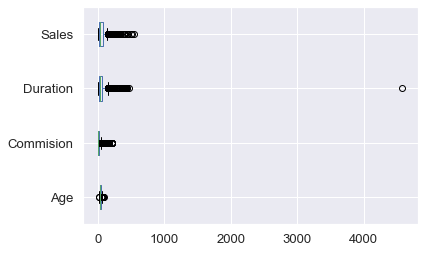

In [1243]:
# construct box plot for continuous variables

df[['Age', 'Type', 'Claimed', 'Commision', 'Channel', 'Duration', 'Sales',
       'Product Name', 'Destination']].boxplot(vert=0)

There are outliers in all the variables. CART and Random Forest are robust to outliers. 
Neural Networks can handle outliers if there are more hidden layers and if the number of outliers is lesser. For now, we will keep the data as it is, and if we find the performance of the neural network to be lesser, then we will treat the outliers and re-build neural network model

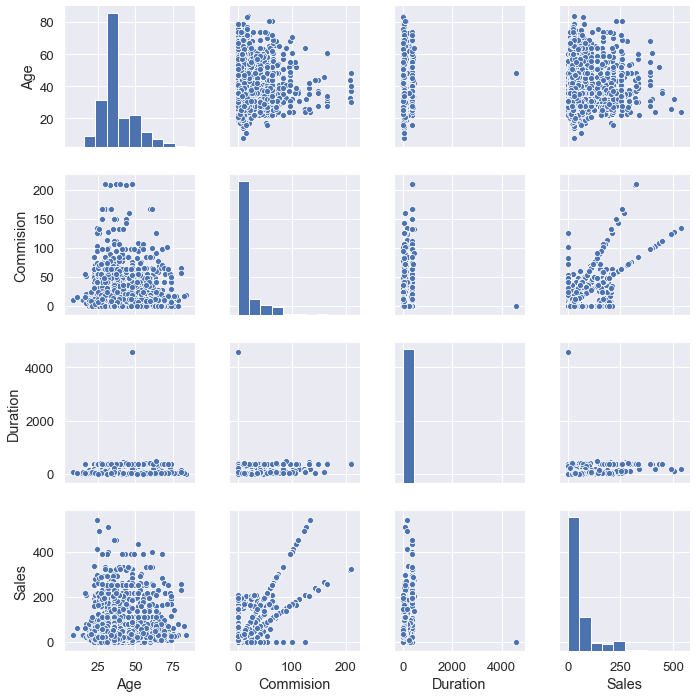

In [1244]:
sns.pairplot(df[['Age', 'Type', 'Claimed', 'Commision', 'Channel', 'Duration', 'Sales',
       'Product Name', 'Destination']])

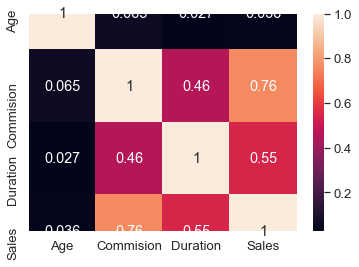

In [1245]:
# construct heatmap with only continuous variables
#plt.figure(figsize=(5,4))
#sns.set(font_scale=1.2)
sns.heatmap(df[['Age', 'Type', 'Claimed', 'Commision', 'Channel', 'Duration', 'Sales',
       'Product Name', 'Destination']].corr(), annot=True)

In [1246]:
### Converting objects into Categorical codes

In [1247]:
for feature in df.columns: 
    if df[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(df[feature].unique()))
        print(pd.Categorical(df[feature].unique()).codes)
        df[feature] = pd.Categorical(df[feature]).codes



feature: Type
[Airlines, Travel Agency]
Categories (2, object): [Airlines, Travel Agency]
[0 1]


feature: Claimed
[No, Yes]
Categories (2, object): [No, Yes]
[0 1]


feature: Channel
[Online, Offline]
Categories (2, object): [Offline, Online]
[1 0]


feature: Product Name
[Customised Plan, Cancellation Plan, Bronze Plan, Silver Plan, Gold Plan]
Categories (5, object): [Bronze Plan, Cancellation Plan, Customised Plan, Gold Plan, Silver Plan]
[2 1 0 4 3]


feature: Destination
[ASIA, Americas, EUROPE]
Categories (3, object): [ASIA, Americas, EUROPE]
[0 1 2]


In [1248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2861 entries, 0 to 2999
Data columns (total 9 columns):
Age             2861 non-null int64
Type            2861 non-null int8
Claimed         2861 non-null int8
Commision       2861 non-null float64
Channel         2861 non-null int8
Duration        2861 non-null int64
Sales           2861 non-null float64
Product Name    2861 non-null int8
Destination     2861 non-null int8
dtypes: float64(2), int64(2), int8(5)
memory usage: 205.7 KB


In [1249]:
df.head(3)

,Age,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0.70,1,7,2.51,2,0
1,36,1,0,0.00,1,34,20.00,2,0
2,39,1,0,5.94,1,3,9.90,2,1


In [1250]:
#Find the number of people who have claimed 

df.Claimed.value_counts(normalize=True)

0    0.680531
1    0.319469
Name: Claimed, dtype: float64

In [1251]:
X = df.drop("Claimed", axis=1)

y = df.pop("Claimed")

X.head()

,Age,Type,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0.70,1,7,2.51,2,0
1,36,1,0.00,1,34,20.00,2,0
2,39,1,5.94,1,3,9.90,2,1
3,36,1,0.00,1,4,26.00,1,0
4,33,0,6.30,1,53,18.00,0,0


In [1252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2861 entries, 0 to 2999
Data columns (total 8 columns):
Age             2861 non-null int64
Type            2861 non-null int8
Commision       2861 non-null float64
Channel         2861 non-null int8
Duration        2861 non-null int64
Sales           2861 non-null float64
Product Name    2861 non-null int8
Destination     2861 non-null int8
dtypes: float64(2), int64(2), int8(4)
memory usage: 202.9 KB


In [1312]:
# Perform Train Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=.25, random_state=None)

In [1313]:
# Check Dimensions of data

print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('train_labels',train_labels.shape)
print('test_labels',test_labels.shape)

X_train (2145, 8)
X_test (716, 8)
train_labels (2145,)
test_labels (716,)


# DECISION TREE CLASSIFIER

In [1315]:
param_grid = {
    'criterion': ['gini'],
    'max_depth': [10,20],
    'min_samples_leaf': [30,35,40], # Usually chosen as 3% of number of rows in dataset
    'min_samples_split': [10,20,40], # Usually 1% of rows in dataset
}

dtcl = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtcl, param_grid = param_grid, cv = 10)

In [1316]:
grid_search.fit(X_train, train_labels)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
best_grid

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 35, 'min_samples_split': 10}


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=35, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [1317]:
### Generating a tree

In [1318]:
train_char_label = ['no', 'yes']
tree_regularized = open('tree_regularized_graph.dot','w')
dot_data = tree.export_graphviz(best_grid, out_file= tree_regularized , feature_names = list(X_train), class_names = list(train_char_label))

tree_regularized.close()
dot_data

In [1319]:
## View the tree on "http://webgraphviz.com/"

In [1320]:
print(pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                   Imp
Product Name  0.648867
Commision     0.145877
Sales         0.141450
Duration      0.030978
Age           0.030438
Destination   0.002390
Type          0.000000
Channel       0.000000


In [1321]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [1322]:
## Getting Predicted Classes and Probs

In [1323]:
ytest_predict
ytest_predict_prob=best_grid.predict_proba(X_test)
ytest_predict_prob
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.500000,0.500000
1,0.121212,0.878788
2,0.923077,0.076923
3,0.750000,0.250000
4,0.243243,0.756757


###  AUC AND ROC For Training Data 

AUC: 0.836


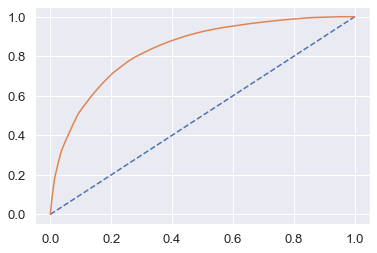

In [1324]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % cart_train_auc)
# calculate roc curve
cart_train_fpr, cart_train_tpr, cart_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_train_fpr, cart_train_tpr)

### AUC AND ROC For Test Data 

AUC: 0.795


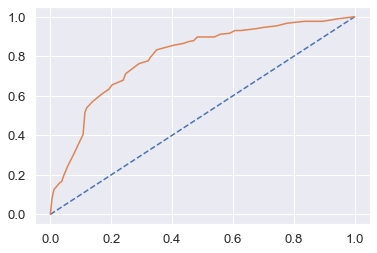

In [1325]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % cart_test_auc)
# calculate roc curve
cart_test_fpr, cart_test_tpr, cart_testthresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_test_fpr, cart_test_tpr)

### CONFUSION MATRIX FOR TRAINING DATA


confusion_matrix(train_labels, ytrain_predict)

In [1326]:
cart_train_acc=best_grid.score(X_train,train_labels) 
cart_train_acc

0.7785547785547785

In [1327]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1446
           1       0.71      0.54      0.61       699

    accuracy                           0.78      2145
   macro avg       0.76      0.72      0.73      2145
weighted avg       0.77      0.78      0.77      2145



In [1328]:
cart_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
cart_df=pd.DataFrame(cart_metrics).transpose()
cart_train_recall=round(cart_df.loc["1"][1],2)
cart_train_f1=round(cart_df.loc["1"][2],2)
cart_train_precision=round(cart_df.loc["1"][0],2)
print ('cart_train_precision ',cart_train_precision)
print ('cart_train_recall ',cart_train_recall)
print ('cart_train_f1 ',cart_train_f1)
print('AUC: %.3f' % cart_train_auc)
print('Train Accuracy :%.3f'% cart_train_acc)

cart_train_precision  0.71
cart_train_recall  0.54
cart_train_f1  0.61
AUC: 0.836
Train Accuracy :0.779


### CONFUSION MATRIX FOR TESTING DATA

In [1329]:
confusion_matrix(test_labels, ytest_predict)

array([[441,  60],
       [ 99, 116]], dtype=int64)

In [1330]:
#Test Data Accuracy
cart_test_acc=best_grid.score(X_test,test_labels)
cart_test_acc

0.7779329608938548

In [1331]:
print(classification_report(test_labels, ytest_predict))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       501
           1       0.66      0.54      0.59       215

    accuracy                           0.78       716
   macro avg       0.74      0.71      0.72       716
weighted avg       0.77      0.78      0.77       716



In [1332]:
cart_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
cart_df=pd.DataFrame(cart_metrics).transpose()
cart_test_recall=round(cart_df.loc["1"][1],2)
cart_test_f1=round(cart_df.loc["1"][2],2)
cart_test_precision=round(cart_df.loc["1"][0],2)
print ('cart_test_precision ',cart_test_precision)
print ('cart_test_recall ',cart_test_recall)
print ('cart_test_f1 ',cart_test_f1)
print('AUC: %.3f' % cart_test_auc)
print('Test Accuracy :%.3f'% cart_test_acc)

cart_test_precision  0.66
cart_test_recall  0.54
cart_test_f1  0.59
AUC: 0.795
Test Accuracy :0.778


In [1333]:
print("\n\n TRAIN \n\n")
print ('cart_train_precision ',cart_train_precision)
print ('cart_train_recall ',cart_train_recall)
print ('cart_train_f1 ',cart_train_f1)
print('AUC: %.3f' % cart_train_auc)
print('Train Accuracy :%.3f'% cart_train_acc)
print("\n\n TEST \n\n")
print ('cart_test_precision ',cart_test_precision)
print ('cart_test_recall ',cart_test_recall)
print ('cart_test_f1 ',cart_test_f1)
print('AUC: %.3f' % cart_test_auc)
print('Test Accuracy :%.3f'% cart_test_acc)



 TRAIN 


cart_train_precision  0.71
cart_train_recall  0.54
cart_train_f1  0.61
AUC: 0.836
Train Accuracy :0.779


 TEST 


cart_test_precision  0.66
cart_test_recall  0.54
cart_test_f1  0.59
AUC: 0.795
Test Accuracy :0.778


<b> CART CONCLUSION AND METRICS </b>

#### Training Data :
    
AUC         : 83.7 %
Accuracy    : 78.4 %
Sensitivity : 71   %
Precision   : 52   %
F1-Score    : 60   %

Testing Data :
    
AUC         : 79   %
Accuracy    : 75.9 %
Sensitivity : 49   %
Precision   : 71   %
F1-Score    : 58   %

# RANDOM FOREST CLASSIFIER

In [1678]:
param_grid = {
    'max_depth': [25],
    'max_features': [6],
    'min_samples_leaf': [4,5,6],
    'min_samples_split': [25,30,35],
    'n_estimators': [150]
}

rfcl = RandomForestClassifier(oob_score=True)

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 20)

In [1679]:
grid_search.fit(X_train, train_labels)

GridSearchCV(cv=20, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=

In [1680]:
grid_search.best_params_

{'max_depth': 25,
 'max_features': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 35,
 'n_estimators': 150}

In [1681]:
best_grid = grid_search.best_estimator_

In [1682]:
best_grid

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=35,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [1683]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [1684]:
confusion_matrix(train_labels,ytrain_predict)

array([[1295,  151],
       [ 243,  456]], dtype=int64)

In [1685]:
rf_train_acc=best_grid.score(X_train,train_labels) 
rf_train_acc

0.8163170163170164

In [1686]:
print(classification_report(train_labels,ytrain_predict))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1446
           1       0.75      0.65      0.70       699

    accuracy                           0.82      2145
   macro avg       0.80      0.77      0.78      2145
weighted avg       0.81      0.82      0.81      2145



In [1687]:
rf_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df_rf=pd.DataFrame(rf_metrics).transpose()
rf_train_precision=round(df_rf.loc["1"][0],2)
rf_train_recall=round(df_rf.loc["1"][1],2)
rf_train_f1=round(df_rf.loc["1"][2],2)
print ('rf_train_precision ',rf_train_precision)
print ('rf_train_recall ',rf_train_recall)
print ('rf_train_f1 ',rf_train_f1)

rf_train_precision  0.75
rf_train_recall  0.65
rf_train_f1  0.7


Area under Curve is 0.7739672561276038


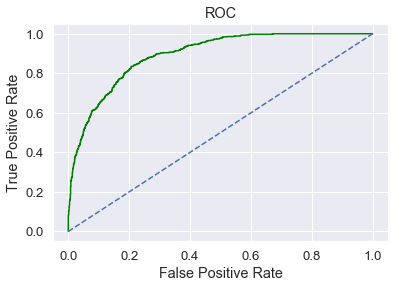

In [1688]:
rf_train_fpr, rf_train_tpr,_=roc_curve(train_labels,best_grid.predict_proba(X_train)[:,1])
plt.plot(rf_train_fpr,rf_train_tpr,color='green')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
rf_train_auc=roc_auc_score(train_labels,best_grid.predict(X_train))
print('Area under Curve is', rf_train_auc)

### RF Model Performance Evaluation on Test Data

In [1689]:
confusion_matrix(test_labels,ytest_predict)

array([[426,  75],
       [ 89, 126]], dtype=int64)

In [1690]:
rf_test_acc=best_grid.score(X_test,test_labels)
rf_test_acc

0.770949720670391

In [1691]:
print(classification_report(test_labels,ytest_predict))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       501
           1       0.63      0.59      0.61       215

    accuracy                           0.77       716
   macro avg       0.73      0.72      0.72       716
weighted avg       0.77      0.77      0.77       716



In [1692]:
rf_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
rf_df=pd.DataFrame(rf_metrics).transpose()
rf_test_precision=round(rf_df.loc["1"][1],2)
rf_test_recall=round(rf_df.loc["1"][2],2)
rf_test_f1=round(rf_df.loc["1"][0],2)
print ('rf_test_precision ',rf_test_precision)
print ('rf_test_recall ',rf_test_recall)
print ('rf_test_f1 ',rf_test_f1)

rf_test_precision  0.59
rf_test_recall  0.61
rf_test_f1  0.63


Area under Curve is 0.7181729564127559


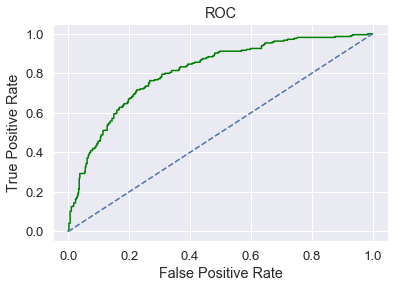

In [1693]:
rf_test_fpr, rf_test_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.plot(rf_test_fpr,rf_test_tpr,color='green')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
rf_test_auc=roc_auc_score(test_labels,best_grid.predict(X_test))
print('Area under Curve is', rf_test_auc)

In [1694]:
print('TRAIN SUMMARY \n')
print('AUC      :%.2f'% rf_train_auc)
print('Accuracy :%.2f'% rf_train_acc)
print ('rf_test_precision : ',rf_train_precision)
print ('rf_test_recall : ',rf_train_recall)
print ('rf_test_f1 : ',rf_train_f1)

print('\n\n\n TEST SUMMARY \n')
print('AUC      :%.2f'% rf_test_auc)
print('Accuracy :%.2f'% rf_test_acc)
print ('rf_test_precision: ',rf_test_precision)
print ('rf_test_recall:',rf_test_recall)
print ('rf_test_f1 :',rf_test_f1)
print('\n\n\n\n')

TRAIN SUMMARY 

AUC      :0.77
Accuracy :0.82
rf_test_precision :  0.75
rf_test_recall :  0.65
rf_test_f1 :  0.7



 TEST SUMMARY 

AUC      :0.72
Accuracy :0.77
rf_test_precision:  0.59
rf_test_recall: 0.61
rf_test_f1 : 0.63







In [1695]:
# Variable Importance
print (pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                   Imp
Product Name  0.334224
Sales         0.213442
Commision     0.143992
Duration      0.132228
Age           0.089662
Type          0.066779
Destination   0.017030
Channel       0.002643


### Random Forest Conclusion

#### Training and Test measures are similar but can be better. ' Product Name' is once again the most important variable influencing the target

## NEURAL NETWORK CLASSIFIER

In [1696]:
param_grid = {
    'hidden_layer_sizes': [45], 
    'max_iter': [8000], 
    'solver': ['adam'], 
    'tol': [0.00001], 
}

nncl = MLPClassifier()

grid_search = GridSearchCV(estimator = nncl, param_grid = param_grid, cv = 15)

In [1697]:
grid_search.fit(X_train, train_labels)
grid_search.best_params_

{'hidden_layer_sizes': 45, 'max_iter': 8000, 'solver': 'adam', 'tol': 1e-05}

In [1698]:
best_grid = grid_search.best_estimator_
best_grid

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=45, learning_rate='constant',
              learning_rate_init=0.001, max_iter=8000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=1e-05,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [1699]:
# Prediction of Train and Test data
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [1700]:
confusion_matrix(train_labels,ytrain_predict)

array([[1338,  108],
       [ 426,  273]], dtype=int64)

In [1701]:
nn_train_acc=best_grid.score(X_train,train_labels) 
nn_train_acc

0.7510489510489511

In [1702]:
print(classification_report(train_labels,ytrain_predict))

              precision    recall  f1-score   support

           0       0.76      0.93      0.83      1446
           1       0.72      0.39      0.51       699

    accuracy                           0.75      2145
   macro avg       0.74      0.66      0.67      2145
weighted avg       0.74      0.75      0.73      2145



In [1703]:
nn_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_train_precision=round(df.loc["1"][0],2)
nn_train_recall=round(df.loc["1"][1],2)
nn_train_f1=round(df.loc["1"][2],2)
print ('nn_train_precision ',nn_train_precision)
print ('nn_train_recall ',nn_train_recall)
print ('nn_train_f1 ',nn_train_f1)

nn_train_precision  0.72
nn_train_recall  0.39
nn_train_f1  0.51


Area under Curve is 0.6579345716168327


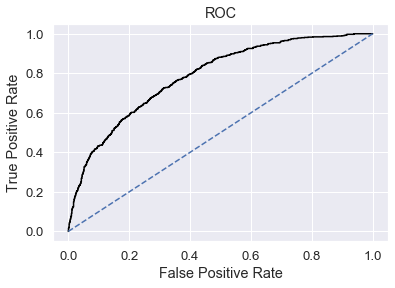

In [1704]:
nn_train_fpr, nn_train_tpr,_=roc_curve(train_labels,best_grid.predict_proba(X_train)[:,1])
plt.plot(nn_train_fpr,nn_train_tpr,color='black')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
nn_train_auc=roc_auc_score(train_labels,best_grid.predict(X_train))
print('Area under Curve is', nn_train_auc)

In [1705]:
## Neural Net Model Performance on Test data


In [1706]:
confusion_matrix(test_labels,ytest_predict)

array([[463,  38],
       [130,  85]], dtype=int64)

In [1707]:
nn_test_acc=best_grid.score(X_test,test_labels)
nn_test_acc

0.7653631284916201

In [1708]:
print(classification_report(test_labels,ytest_predict))

              precision    recall  f1-score   support

           0       0.78      0.92      0.85       501
           1       0.69      0.40      0.50       215

    accuracy                           0.77       716
   macro avg       0.74      0.66      0.67       716
weighted avg       0.75      0.77      0.74       716



In [1709]:
nn_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_test_precision=round(df.loc["1"][0],2)
nn_test_recall=round(df.loc["1"][1],2)
nn_test_f1=round(df.loc["1"][2],2)
print ('nn_test_precision ',nn_test_precision)
print ('nn_test_recall ',nn_test_recall)
print ('nn_test_f1 ',nn_test_f1)

nn_test_precision  0.69
nn_test_recall  0.4
nn_test_f1  0.5


Area under Curve is 0.6597502669080444


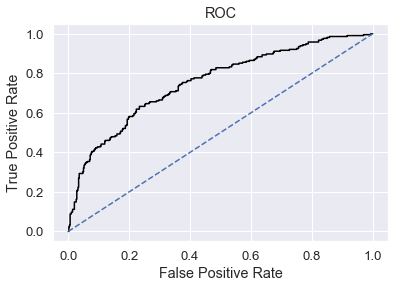

In [1710]:
nn_test_fpr, nn_test_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.plot(nn_test_fpr,nn_test_tpr,color='black')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
nn_test_auc=roc_auc_score(test_labels,best_grid.predict(X_test))
print('Area under Curve is', nn_test_auc)

In [1711]:
best_grid.score

<bound method ClassifierMixin.score of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=45, learning_rate='constant',
              learning_rate_init=0.001, max_iter=8000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=1e-05,
              validation_fraction=0.1, verbose=False, warm_start=False)>

In [1712]:
print('TRAIN SUMMARY \n')
print('AUC      :%.2f'% nn_train_auc)
print('Accuracy :%.2f'% nn_train_acc)
print ('test_precision : ',nn_train_precision)
print ('test_recall : ',nn_train_recall)
print ('test_f1 : ',nn_train_f1)

print('\n\n\n TEST SUMMARY \n')
print('AUC      :%.2f'% nn_test_auc)
print('Accuracy :%.2f'% nn_test_acc)
print ('test_precision: ',nn_test_precision)
print ('test_recall:',nn_test_recall)
print ('test_f1 :',nn_test_f1)
print('\n\n\n\n')

TRAIN SUMMARY 

AUC      :0.66
Accuracy :0.75
test_precision :  0.72
test_recall :  0.39
test_f1 :  0.51



 TEST SUMMARY 

AUC      :0.66
Accuracy :0.77
test_precision:  0.69
test_recall: 0.4
test_f1 : 0.5







In [1713]:
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data = pd.DataFrame({'CART Train':[cart_train_acc,cart_train_auc,cart_train_recall,cart_train_precision,cart_train_f1],
        'CART Test':[cart_test_acc,cart_test_auc,cart_test_recall,cart_test_precision,cart_test_f1],
       'Random Forest Train':[rf_train_acc,rf_train_auc,rf_train_recall,rf_train_precision,rf_train_f1],
        'Random Forest Test':[rf_test_acc,rf_test_auc,rf_test_recall,rf_test_precision,rf_test_f1],
       'Neural Network Train':[nn_train_acc,nn_train_auc,nn_train_recall,nn_train_precision,nn_train_f1],
        'Neural Network Test':[nn_test_acc,nn_test_auc,nn_test_recall,nn_test_precision,nn_test_f1]},index=index)
round(data,2)

,CART Train,CART Test,Random Forest Train,Random Forest Test,Neural Network Train,Neural Network Test
Accuracy,0.78,0.78,0.82,0.77,0.75,0.77
AUC,0.84,0.80,0.77,0.72,0.66,0.66
Recall,0.54,0.54,0.65,0.61,0.39,0.40
Precision,0.71,0.66,0.75,0.59,0.72,0.69
F1 Score,0.61,0.59,0.70,0.63,0.51,0.50


### ROC Curve for the 3 models on the Train data

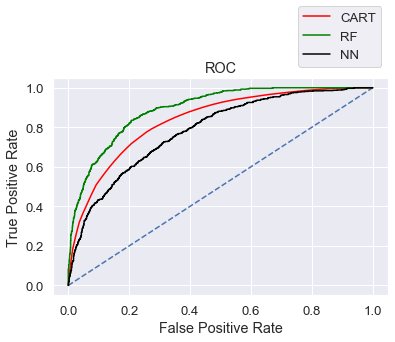

In [1714]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_train_fpr, cart_train_tpr,color='red',label="CART")
plt.plot(rf_train_fpr,rf_train_tpr,color='green',label="RF")
plt.plot(nn_train_fpr,nn_train_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

### ROC Curve for the 3 models on the Test data

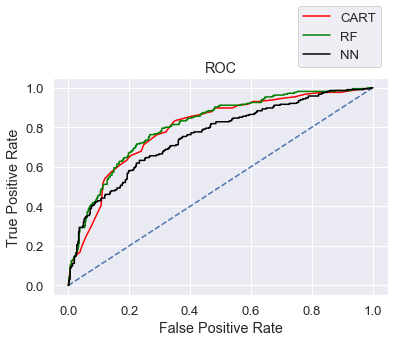

In [1715]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_test_fpr, cart_test_tpr,color='red',label="CART")
plt.plot(rf_test_fpr,rf_test_tpr,color='green',label="RF")
plt.plot(nn_test_fpr,nn_test_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')